# Predicting customer lifetime value and future purchases 

In most cases value of a firm is profits from existing and future customers (a.k.a. Customer Equity). Research done by Frederick Reichheld of Bain & Company (the inventor of the net promoter score) shows increasing customer retention rates by 5% increases profits by 25% to 95% (Reichheld 2001). 

It is possible to calculate Customer Equity (CE) because Customer Lifetime Value (CLV) can be measured with a reasonable degree of precision.

*CLV is the present value of the future (net) cash flows associated with the customer (Gupta and Lehmann 2003). It is a forward-looking concept, not to be confused with historic customer profitability.*

Not all customers are equally important to a firm. Maintaining long-term relation with all of them (especially the loss makers) is not optimal because eventually marketing is all about attracting and retaining profitable customers (Kotler and Armstrong 1996). Hence the objective of CLV is firstly on general topics of firm’s profitability and secondly as an input in customer acquisition decision and customer acquisition/retention trade-offs (Berger and Nasr 1998).


## Objectives

The primary goal of this work is to build a probabilistic model for forecasting customer lifetime value in non-contractual setting on an individual level. 

Using the results of this exercise, managers should be able to: 
1. Distinguish active customers from inactive customers. 
2. Generate transaction forecasts for individual customers.
3. Predict the purchase volume of the entire customer base.

## Import packages

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes

#Let's make this notebook reproducible 
np.random.seed(42)

import random
random.seed(42)

import warnings
warnings.filterwarnings('ignore')

#### Plotting parameters

In [2]:
# Make the default figures a bit bigger
plt.rcParams['figure.figsize'] = (7,4.5) 
plt.rcParams["figure.dpi"] = 140 

sns.set(style="ticks")
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 5})

## Read data

Reading in transaction log. i.e. Amount spent per customer each day

In [3]:
df1 = pd.read_csv('../input/olist_orders_dataset.csv')
df2 = pd.read_csv('../input/olist_customers_dataset.csv')
df3 = pd.read_csv('../input/olist_order_payments_dataset.csv')

cols = ['customer_id', 'order_id', 'order_purchase_timestamp']
orders = df1[cols]
orders = orders.set_index('customer_id')
orders.drop_duplicates(inplace=True)

# too few 
cols = ['order_id', 'payment_value']
payment = df3[cols]
payment = payment.set_index('order_id')
payment.drop_duplicates(inplace=True)

cols = ['customer_id', 'customer_unique_id']
customers = df2[cols]
customers = customers.set_index('customer_id')

elog = pd.concat([orders,customers], axis=1, join='inner')
elog.reset_index(inplace=True)

cols = ['customer_unique_id', 'order_purchase_timestamp']
elog = elog[cols]

elog['order_purchase_timestamp'] = pd.to_datetime(elog['order_purchase_timestamp'])
elog['order_date'] = elog.order_purchase_timestamp.dt.date
elog['order_date'] = pd.to_datetime(elog['order_date'])

cols = ['customer_unique_id', 'order_date']
elog = elog[cols]

elog.columns = ['CUSTOMER_ID', 'ORDER_DATE']


elog.info()
display(elog.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 2 columns):
CUSTOMER_ID    99441 non-null object
ORDER_DATE     99441 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 1.5+ MB


,CUSTOMER_ID,ORDER_DATE
52263,2d1bf256227e4d22d10ea6c0b81809d7,2018-06-12
46645,12bf514b8d413d8cbe66a2665f4b724c,2018-01-20
37546,83c6df0d47130de38c99cebe96521e8a,2018-06-16
94756,29b186723b197669f69b7d63c3e27c07,2017-08-30
14771,a59129ed35da4c3e3f2a005b4c6582fc,2017-08-10


#### Date range of orders

In [4]:
elog.ORDER_DATE.describe()

count                   99441
unique                    634
top       2017-11-24 00:00:00
freq                     1176
first     2016-09-04 00:00:00
last      2018-10-17 00:00:00
Name: ORDER_DATE, dtype: object

## Creating RFM Matrix based on transaction log

#### Spliting calibration and holdout period

In [5]:
%%time
calibration_period_ends = '2018-06-30'

from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(elog, 
                                                   customer_id_col = 'CUSTOMER_ID', 
                                                   datetime_col = 'ORDER_DATE', 
                                                   freq = 'D', #days
                                        calibration_period_end=calibration_period_ends,
                                        observation_period_end='2018-09-28' )


CPU times: user 33.3 s, sys: 836 ms, total: 34.2 s
Wall time: 33.2 s


### Feature set

In [6]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CUSTOMER_ID,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,51.0,0.0,90
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,54.0,0.0,90
0000f46a3911fa3c0805444483337064,0.0,0.0,477.0,0.0,90
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,261.0,0.0,90
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,228.0,0.0,90


## Training model - MBG/NBD 

Model assumptions:

* While active, the number of transactions made by a customer follows a Poisson process
with transaction rate $\lambda$.
* Heterogeneity in $\lambda$ across customers follows a Gamma distribution with shape parameter $r$ and scale parameter $\alpha$.
* At time zero and right after each purchase the customer becomes inactive with a constant probability $p$.
* Heterogeneity in $p$ across customers follows a Gamma distribution with parameter $a$ and $b$.
* The transaction rate $\lambda$ and the dropout probability $p$ vary independently across customers.



In [7]:
%%time 

from lifetimes import ModifiedBetaGeoFitter

mbgnbd = ModifiedBetaGeoFitter(penalizer_coef=0.01)
mbgnbd.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'],
       verbose=True)

Optimize function with Nelder-Mead
Optimization terminated successfully.
         Current function value: 0.085065
         Iterations: 409
         Function evaluations: 695
CPU times: user 18.7 s, sys: 0 ns, total: 18.7 s
Wall time: 18.7 s


In [8]:
print(mbgnbd)

<lifetimes.ModifiedBetaGeoFitter: fitted with 83748 subjects, a: 0.22, alpha: 218.07, b: 0.12, r: 0.10>


### Estimating customer lifetime value using the Gamma-Gamma model

The Gamma-Gamma model and the independence assumption:

Model assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [9]:
#returning_customers_summary = summary_cal_holdout[summary_cal_holdout['frequency_cal'] > 0]
#returning_customers_summary[['monetary_value_cal', 'frequency_cal']].corr()

In [10]:
#%%time 

#from lifetimes import GammaGammaFitter

#gg = GammaGammaFitter(penalizer_coef = 0.01)
#gg.fit(returning_customers_summary['frequency_cal'],
#        returning_customers_summary['monetary_value_cal'],
#       verbose=True)

In [11]:
#print(gg)

### Predictions for each customer

In [12]:
t = 90 # days to predict in the future 
summary_cal_holdout['predicted_purchases'] = mbgnbd.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      summary_cal_holdout['frequency_cal'], 
                                                                                      summary_cal_holdout['recency_cal'], 
                                                                                      summary_cal_holdout['T_cal'])

summary_cal_holdout['p_alive'] = mbgnbd.conditional_probability_alive(summary_cal_holdout['frequency_cal'], 
                                                                         summary_cal_holdout['recency_cal'], 
                                                                         summary_cal_holdout['T_cal'])
summary_cal_holdout['p_alive'] = np.round(summary_cal_holdout['p_alive'] / summary_cal_holdout['p_alive'].max(), 2)

#summary_cal_holdout['clv'] = gg.customer_lifetime_value(
#    mbgnbd, #the model to use to predict the number of future transactions
#    summary_cal_holdout['frequency_cal'],
#    summary_cal_holdout['recency_cal'],
#    summary_cal_holdout['T_cal'],
#    summary_cal_holdout['monetary_value_cal'],
#    time=3, # months
#    discount_rate=0 #0.0025 # = 0.03/12 monthly discount rate ~ 3% annually
#)
#summary_cal_holdout['clv'] += (-1*summary_cal_holdout['clv'].min())

In [13]:
display(summary_cal_holdout.sample(2).T)

CUSTOMER_ID,a12a52a129241056f2224794d70774ee,f2ba66a2a2704983864ee770bb9afdb6
frequency_cal,0.000000,0.000000
recency_cal,0.000000,0.000000
T_cal,352.000000,466.000000
frequency_holdout,0.000000,0.000000
duration_holdout,90.000000,90.000000
predicted_purchases,0.004967,0.004098
p_alive,0.340000,0.330000


## Model evaluation

### Accessing model fit

CPU times: user 26.5 s, sys: 268 ms, total: 26.7 s
Wall time: 26.4 s


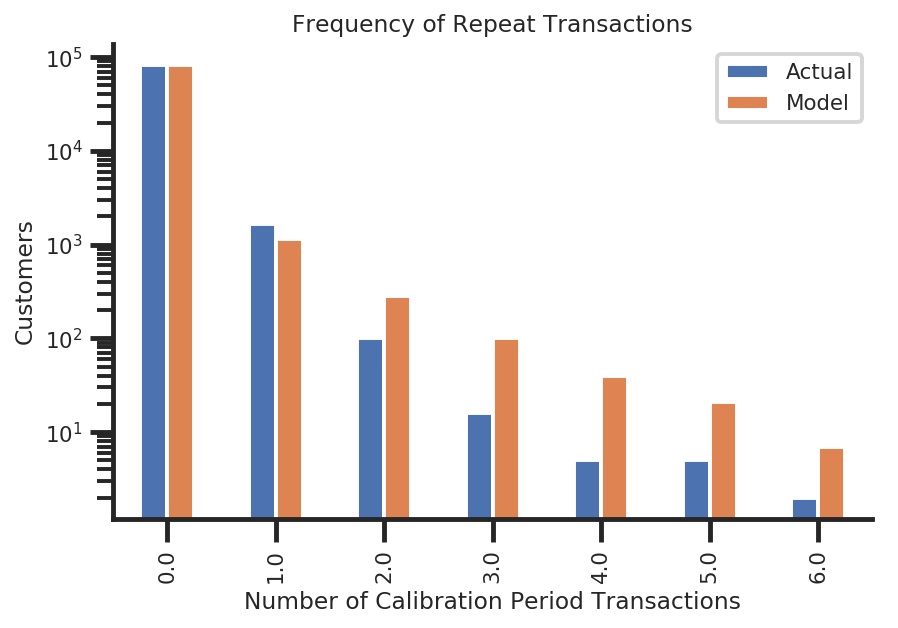

In [14]:
%%time 

from lifetimes.plotting import plot_period_transactions
ax = plot_period_transactions(mbgnbd, max_frequency=7)
ax.set_yscale('log')
sns.despine();

CPU times: user 5.88 s, sys: 16 ms, total: 5.9 s
Wall time: 5.9 s


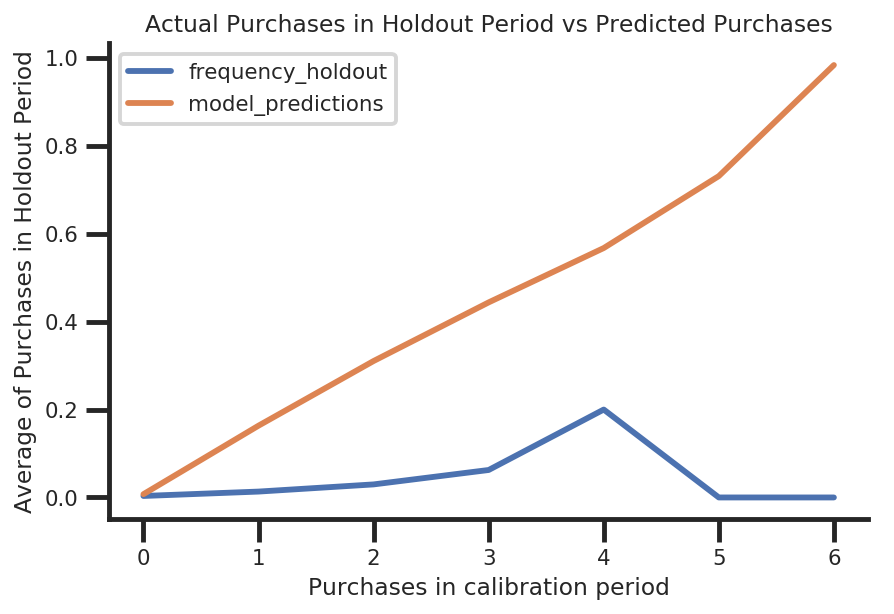

In [15]:
%%time 

from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(mbgnbd, summary_cal_holdout)
sns.despine();

### Customer Probability History

Probability that customer is alive today is 0.32


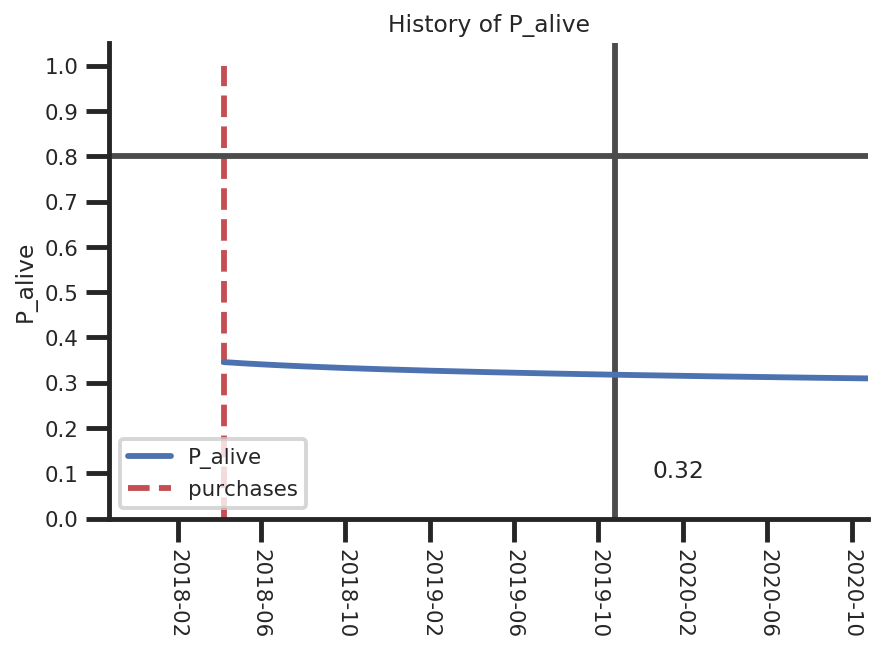

In [16]:
from lifetimes.plotting import plot_history_alive
from datetime import date
from pylab import figure, text, scatter, show

individual = summary_cal_holdout.iloc[4942]

id = individual.name
t = 365*50

today = date.today()
two_year_ago = today.replace(year=today.year - 2)
one_year_from_now = today.replace(year=today.year + 1)

sp_trans = elog.loc[elog['CUSTOMER_ID'] == id]

from lifetimes.utils import calculate_alive_path

t = (today - sp_trans.ORDER_DATE.min().date()).days
p_alive_today = pd.DataFrame(calculate_alive_path(mbgnbd, sp_trans, 'ORDER_DATE', t, freq='D'))[0].tail(1).values
p_alive_today = np.round(p_alive_today[0], 2)
print('Probability that customer is alive today is', p_alive_today)

t = (one_year_from_now - sp_trans.ORDER_DATE.min().date()).days
ax = plot_history_alive(mbgnbd, t, sp_trans, 'ORDER_DATE', start_date=two_year_ago) #, start_date='2016-01-01'
ax.vlines(x=today, ymin=0, ymax=1.05, colors='#4C4C4C')
ax.hlines(y=0.8, xmin=two_year_ago, xmax=one_year_from_now, colors='#4C4C4C')

ax.set_xlim(two_year_ago, one_year_from_now) # sp_trans.ORDER_DATE.min()
ax.set_ylim(0, 1.05)

plt.xticks(rotation=-90)
text(0.75, 0.1, p_alive_today, ha='center', va='center', transform=ax.transAxes)

sns.despine()

### Predicted Transactions with Time

In [17]:
elog.columns = ['CUSTOMER_ID', 'date']

In [18]:
%%time
# Get expected and actual repeated cumulative transactions.

from lifetimes.utils import expected_cumulative_transactions

t = (elog.date.max() - elog.date.min()).days
df = expected_cumulative_transactions(mbgnbd, elog, 'date', 'CUSTOMER_ID', t)

CPU times: user 16.1 s, sys: 8 ms, total: 16.1 s
Wall time: 16.1 s


In [19]:
df.tail()

,actual,predicted
768,2383,3875.192539
769,2383,3888.110176
770,2383,3901.022372
771,2383,3913.929139
772,2384,3926.830493


CPU times: user 16.1 s, sys: 8 ms, total: 16.1 s
Wall time: 16.1 s


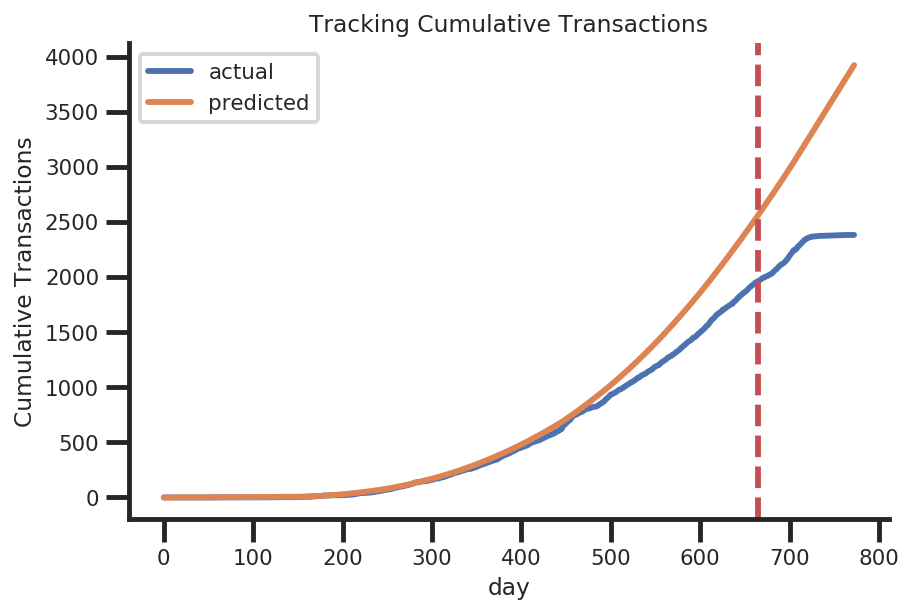

In [20]:
%%time
# Calibration period = 2016-09-04 to 2017-09-30
from datetime import datetime

cal = datetime.strptime('2018-06-30', '%Y-%m-%d')

from lifetimes.plotting import plot_cumulative_transactions
t = (elog.date.max() - elog.date.min()).days
t_cal = (cal - elog.date.min()).days
plot_cumulative_transactions(mbgnbd, elog, 'date', 'CUSTOMER_ID', t, t_cal, freq='D')
sns.despine()

CPU times: user 16.2 s, sys: 12 ms, total: 16.2 s
Wall time: 16.2 s


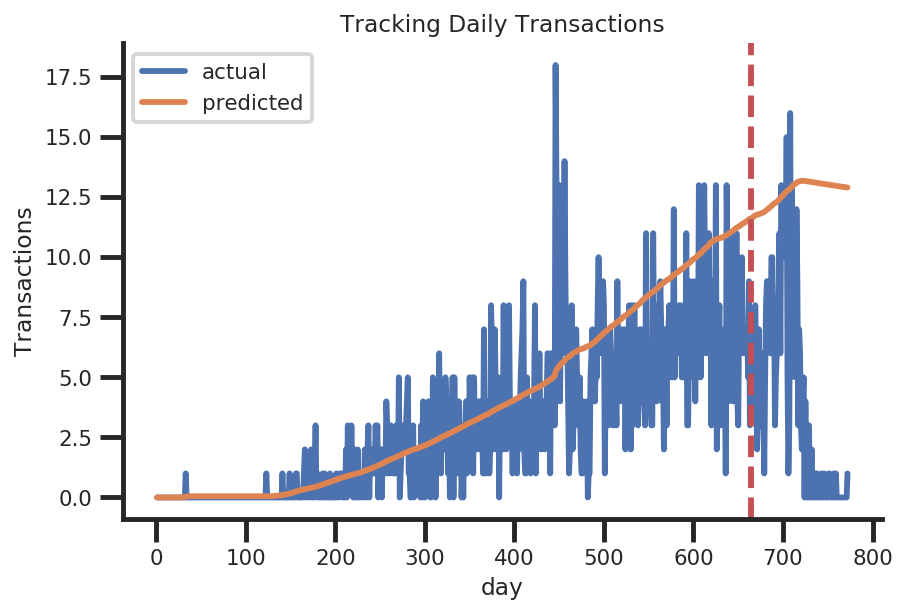

In [21]:
%%time 

from lifetimes.plotting import plot_incremental_transactions
plot_incremental_transactions(mbgnbd, elog, 'date', 'CUSTOMER_ID', t, t_cal, freq='D')
sns.despine()

### Predict the conditional, expected average lifetime value of our customers.


In [22]:
#print("Expected conditional average revenue: €%s, Average revenue: €%s" % (
#    np.round(gg.conditional_expected_average_profit(
#        returning_customers_summary['frequency_cal'],
#        returning_customers_summary['monetary_value_cal']
#    ).mean(), 2),
#    np.round(returning_customers_summary[returning_customers_summary['frequency_cal']>0]['monetary_value_cal'].mean(), 2)
#))

### Model performance will increase if it is trained on all the data and not a sample as is the case here

Cheers..

https://github.com/1dhiman 

http://linkedin.com/in/dhimananubhav